In [680]:
import MetaTrader5 as mt5
import pandas as pd
from datetime import datetime
import time
import requests
import pandas_ta as pta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [481]:
def pull_data(symbol, timeframe, _start, _end):
    
    mt5.initialize()

    login = 121391564
    password = 'xxxx'
    server = 'Exness-MT5Trial7'
    mt5.login(login, password, server)

    raw_df = mt5.copy_rates_range(symbol, timeframe, _start, _end)
    df = pd.DataFrame(raw_df)

    mt5.shutdown()

    df.loc[:,'time'] = pd.to_datetime(df.loc[:,'time'], unit = 's')

    return df

In [482]:
# function to look for trading signals, what trend is now?

def convert_rsi_signal(df, rsi_period = 14, overbought = 70, oversold = 30) :
    if 'close' in df.columns:
        df['rsi'] = pta.rsi(df.close, rsi_period)
        df['signal'] = 'normal'
        df.loc[df['rsi'] < oversold, 'signal'] = 'buy'
        df.loc[df['rsi'] > overbought, 'signal'] = 'sell'
        return df
    else :
        return "Error RSI"

In [692]:
def backtest_rsi(df, rsi_period = 14, overbought = 70, oversold = 30, tp_buy = 50, tp_sell = 50, sl = -1):
    
    t0 = time.time()
    #Genarate signals and details
    df = convert_rsi_signal(df, rsi_period, overbought, oversold)
    df['cross_down'] = (df['rsi'] < tp_sell ) & (df['rsi'].shift(1) > tp_sell)
    df['cross_up'] = (df['rsi'] > tp_buy) & (df['rsi'].shift(1) < tp_buy)
    df['position_price'] = df['open'].shift(-1)
    
    t1 = time.time() - t0
    #Record positions history
    status = 0
    current_order = 'empty'
    df['open_position_price'] = None
    df['profit'] = 0
    df['drawdown'] = 0
    df['cum_profit'] = 0
    df['buy_hold'] = 0
    cum_profit = 0
    t2 = time.time() - t1 - t0
    
    for ind in df.index:
        #if there is an order.
        if status == 1:
            #Calculate drawdown of the current bar
            if current_order == 'buy':
                df.loc[ind, 'drawdown'] = (df.loc[ind, 'low'] - order_price)       #/order_price)*100
            elif current_order == 'sell':
                df.loc[ind, 'drawdown'] = (order_price - df.loc[ind, 'high'])      #/order_price)*100
            
            # condition to close an order : 1.stop loss ,2.take profit
            # tp
            if df.loc[ind, 'drawdown'] > sl:
                if df['cross_up'][ind] & (current_order == 'buy'):
                    profit = df.loc[ind, 'position_price'] - order_price
                    df.loc[ind, 'profit'] = profit
                    df.loc[ind, 'open_position_price'] = order_price
                    status = 0
                    current_order = 'empty'
                    cum_profit += profit

                elif df['cross_down'][ind] & (current_order == 'sell'):
                    profit = order_price - df.loc[ind, 'position_price']
                    df.loc[ind, 'profit'] = profit
                    df.loc[ind, 'open_position_price'] = order_price
                    status = 0
                    current_order = 'empty'
                    cum_profit += profit
                
            # sl
            elif df.loc[ind, 'drawdown'] < sl:
                df.loc[ind, 'profit'] = sl
                df.loc[ind, 'open_position_price'] = order_price
                profit = sl
                status = 0
                current_order = 'empty'
                cum_profit += profit

        df.loc[ind, 'cum_profit'] = cum_profit
            
        #if there is no order, open position if there is a signal
        if df['signal'][ind] == 'buy':
            if status == 0:
                order_price = df['position_price'][ind]
                status = 1
                current_order = 'buy'
        elif df['signal'][ind] == 'sell':
            if status == 0:
                order_price = df['position_price'][ind]
                status = 1
                current_order = 'sell'

        df.loc[ind, 'buy_hold'] = df.loc[ind, 'close'] - df.loc[0, 'open']
        
    t3 = time.time() - t2 - t1 - t0
    total_profit = df['profit'].sum()
    max_dd = df['drawdown'].min()

    return df, total_profit, max_dd, (t1, t2, t3)

In [723]:
SYMBOL = "XAUUSD"
TIMEFRAME = mt5.TIMEFRAME_H1
PERIOD = 12
OVERBOUGHT = 74
OVERSOLD = 26   #26
TP_BUY = 50
TP_SELL = 40
SL = -5     #-5

START_DATE = datetime(2022, 1, 1) #h1 pull after 2021-3-19
END_DATE = datetime(2023, 5, 31)

df = pull_data(SYMBOL, TIMEFRAME, START_DATE, END_DATE)
df, profit, max_dd, t = backtest_rsi(df, PERIOD, OVERBOUGHT, OVERSOLD, TP_BUY, TP_SELL, SL)
profit, max_dd

(262.1499999999992, -30.263999999999896)

In [724]:
df_test = pull_data(SYMBOL, TIMEFRAME, datetime(2023, 6, 1), datetime(2023, 12, 31))
df_test, profit_test, max_dd_test, _ = backtest_rsi(df_test, PERIOD, OVERBOUGHT, OVERSOLD, TP_BUY, TP_SELL, SL)
profit_test, max_dd_test

(19.962999999999965, -7.963999999999942)

In [725]:
df[df['profit'] != 0]

,time,open,high,low,close,tick_volume,spread,real_volume,rsi,signal,cross_down,cross_up,position_price,open_position_price,profit,drawdown,cum_profit,buy_hold
20,2022-01-03 15:00:00,1802.939,1806.595,1799.831,1801.917,8401,62,0,12.079287,buy,False,False,1801.911,1806.968,-5.000,-7.137,-5.000,-23.458
41,2022-01-04 13:00:00,1801.247,1807.328,1799.783,1807.219,6534,62,0,50.837720,normal,False,True,1807.229,1801.911,5.318,-2.128,0.318,-18.156
71,2022-01-05 20:00:00,1812.970,1814.250,1808.327,1810.052,5293,62,0,36.111578,normal,True,False,1810.021,1825.604,15.583,11.354,15.901,-15.323
82,2022-01-06 08:00:00,1800.971,1802.048,1794.556,1795.503,5424,62,0,18.847016,buy,False,False,1795.472,1802.025,-5.000,-7.469,10.901,-29.872
87,2022-01-06 13:00:00,1791.735,1793.229,1786.897,1788.506,9828,62,0,24.066359,buy,False,False,1788.484,1795.472,-5.000,-8.575,5.901,-36.869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8153,2023-05-18 08:00:00,1974.608,1976.207,1972.215,1975.335,5231,62,0,31.843190,normal,False,False,1975.405,1977.718,-5.000,-5.503,265.627,149.960
8158,2023-05-18 13:00:00,1967.088,1968.229,1956.632,1959.927,13193,62,0,18.617746,buy,False,False,1959.906,1967.088,-5.000,-10.456,260.627,134.552
8159,2023-05-18 14:00:00,1959.906,1962.080,1954.434,1955.376,8772,62,0,16.106477,buy,False,False,1955.407,1959.906,-5.000,-5.472,255.627,130.001
8175,2023-05-19 07:00:00,1964.444,1967.923,1964.363,1966.935,4743,62,0,55.514340,normal,False,True,1966.930,1955.407,11.523,8.956,267.150,141.560


<AxesSubplot:>

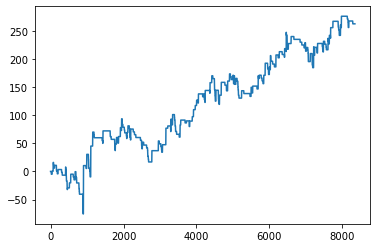

In [726]:
df['cum_profit'].plot()

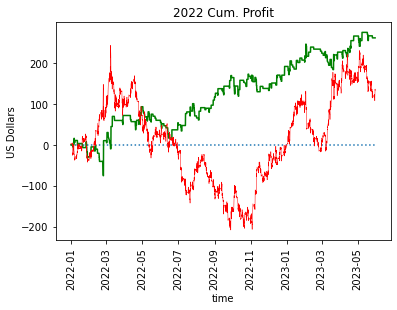

In [727]:
sns.lineplot(data = df, x = 'time', y = 'cum_profit', color = 'g')
sns.lineplot(data = df, x = 'time', y = 'buy_hold', color = 'r', linewidth = 0.5)
plt.xticks(rotation = 90)
plt.hlines(y = 0, linestyles='dotted', xmin = START_DATE, xmax= END_DATE)
plt.title("2022 Cum. Profit")
plt.ylabel("US Dollars")
plt.show()

<AxesSubplot:>

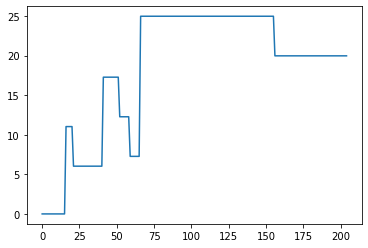

In [701]:
df_test['cum_profit'].plot()

### BUY OPTIMIZATION

In [302]:
# function to look for trading signals, what trend is now?

def convert_rsi_signal_buy(df, rsi_period = 14, oversold = 30) :
    if 'close' in df.columns:
        df['rsi'] = pta.rsi(df.close, rsi_period)
        df['signal'] = 'normal'
        df.loc[df['rsi'] < oversold, 'signal'] = 'buy'
        return df
    else :
        return "Error RSI"

In [316]:
#buy order opm
def backtest_rsi_buy(df, rsi_period = 14,oversold = 30, tp_buy = 50, sl = -1):
    
    t0 = time.time()
    #Genarate signals and details
    df = convert_rsi_signal_buy(df, rsi_period, oversold)
    df['cross_up'] = (df['rsi'] > tp_buy ) & (df['rsi'].shift(1) < tp_buy)
    df['position_price'] = df['open'].shift(-1)
    
    t1 = time.time() - t0
    #Record positions history
    status = 0
    current_order = 'empty'
    df['profit'] = 0
    df['drawdown'] = 0

    t2 = time.time() - t1 - t0
    
    for ind in df.index:
        #Time series run time
        if status == 1:
            if current_order == 'buy':
                df.loc[ind, 'drawdown'] = df.loc[ind, 'low'] - order_price
            
            if df.loc[ind, 'drawdown'] > sl:
                if df['cross_up'][ind]:
                    df.loc[ind, 'profit'] = df.loc[ind, 'position_price'] - order_price
                    status = 0
                    current_order = 'empty'
            elif df.loc[ind, 'drawdown'] < sl:
                df.loc[ind, 'profit'] = sl
                df.loc[ind, 'open_position_price'] = order_price
                status = 0
                current_order = 'empty'

        if df['signal'][ind] == 'buy':
            if status == 0:
                order_price = df['position_price'][ind]
                status = 1
                current_order = 'buy'
    
    t3 = time.time() - t2 - t1 - t0
    total_profit = df['profit'].sum()
    max_dd = df['drawdown'].min()

    return df, total_profit, max_dd, (t1, t2, t3)

In [639]:
START_DATE = datetime(2023, 1, 1) #h1 pull after 2021-3-19
END_DATE = datetime(2023, 5, 31)
df_buy = pull_data(SYMBOL, TIMEFRAME, START_DATE, END_DATE)
df_buy, result, max_dd, t = backtest_rsi_buy(df_buy, rsi_period = 12, oversold = 18, tp_buy = 64, sl = -1)
result, max_dd, t

(35.09100000000035,
 -8.113000000000056,
 (0.011971235275268555, 0.000997781753540039, 0.36448073387145996))

In [612]:
#for buy
rsi_periods_range = np.arange(10, 16, 1) #6
OVERSOLD_range = np.arange(16,25,1) #9
TP_BUY_range = np.arange(60,66,1) #5
SL_range = np.arange(-1, -5, -1)

START_DATE = datetime(2023, 1, 1) #h1 pull after 2021-3-19
END_DATE = datetime(2023, 5, 31)

df = pull_data(SYMBOL, TIMEFRAME, START_DATE, END_DATE)
buy_opm = []

for _rsi_period in rsi_periods_range:
    for ovs in OVERSOLD_range:
        for tp_buy in TP_BUY_range:
            for s in SL_range :
                df, result, max_dd, t = backtest_rsi_buy(df, _rsi_period, ovs, tp_buy, sl = s)
                buy_opm.append((_rsi_period, ovs, tp_buy, s, result, max_dd))
                print(_rsi_period, ovs, tp_buy, s, result, max_dd)
print(buy_opm)

10 16 60 -1 5.688000000000329 -8.113000000000056
10 16 60 -2 15.881000000000768 -8.113000000000056
10 16 60 -3 -29.487999999999374 -11.760999999999967
10 16 60 -4 1.1410000000007585 -11.760999999999967
10 16 61 -1 7.334000000000287 -8.113000000000056
10 16 61 -2 17.527000000000726 -8.113000000000056
10 16 61 -3 -35.209999999999354 -11.760999999999967
10 16 61 -4 -3.7979999999993197 -11.760999999999967
10 16 62 -1 12.204000000000178 -8.113000000000056
10 16 62 -2 25.62400000000048 -8.113000000000056
10 16 62 -3 -26.874999999999773 -11.760999999999967
10 16 62 -4 4.537000000000262 -11.760999999999967
10 16 63 -1 13.13000000000011 -8.113000000000056
10 16 63 -2 30.23100000000045 -8.113000000000056
10 16 63 -3 -20.92999999999961 -11.760999999999967
10 16 63 -4 12.793000000000347 -11.760999999999967
10 16 64 -1 -0.8730000000000473 -8.113000000000056
10 16 64 -2 14.228000000000293 -8.113000000000056
10 16 64 -3 -38.932999999999765 -25.733999999999924
10 16 64 -4 -6.194999999999709 -25.733999

In [618]:
test_buy = pd.DataFrame(buy_opm)
test_buy.columns = 'period', 'ovs', 'tp_buy', 'sl', 'profit', 'drawdown'
print(test_buy.sort_values('profit', ascending= False).head(10))

      period  ovs  tp_buy  sl  profit  drawdown
1197      15   20      65  -2  59.332    -8.113
1196      15   20      65  -1  57.952    -8.113
981       14   20      65  -2  57.418   -13.469
741       13   19      65  -2  57.155    -8.113
737       13   19      64  -2  54.698    -8.113
729       13   19      62  -2  53.745    -8.113
733       13   19      63  -2  53.745    -8.113
1193      15   20      64  -2  51.696    -8.113
764       13   20      65  -1  51.225   -13.469
1192      15   20      64  -1  51.184    -8.113


### SELL OPTIMIZATION

In [321]:
def convert_rsi_signal_sell(df, rsi_period = 14, overbought = 70) :
    if 'close' in df.columns:
        df['rsi'] = pta.rsi(df.close, rsi_period)
        df['signal'] = 'normal'
        df.loc[df['rsi'] > overbought, 'signal'] = 'sell'
        return df
    else :
        return "Error RSI"

In [328]:
#sell order opm
def backtest_rsi_sell(df, rsi_period = 14, overbought = 70, tp_sell = 50, sl = -1):
    
    t0 = time.time()
    #Genarate signals and details
    df = convert_rsi_signal_sell(df, rsi_period, overbought)
    df['cross_down'] = (df['rsi'] < tp_sell ) & (df['rsi'].shift(1) > tp_sell)
    df['position_price'] = df['open'].shift(-1)
    
    t1 = time.time() - t0
    #Record positions history
    status = 0
    current_order = 'empty'
    df['profit'] = 0
    df['drawdown'] = 0

    t2 = time.time() - t1 - t0
    
    for ind in df.index:
        
        if status == 1:
            #Drawdown
            if current_order == 'sell':
                df.loc[ind, 'drawdown'] =  order_price - df.loc[ind, 'high']

            if df.loc[ind, 'drawdown'] > sl:
                if df['cross_down'][ind]:
                    df.loc[ind, 'profit'] = order_price - df.loc[ind, 'position_price']
                    status = 0
                    current_order = 'empty'
            elif df.loc[ind, 'drawdown'] < sl:
                df.loc[ind, 'profit'] = sl
                status = 0
                current_order = 'empty'

        #Time series run time
        if df['signal'][ind] == 'sell':
            if status == 0:
                order_price = df['position_price'][ind]
                status = 1
                current_order = 'sell'
    
    t3 = time.time() - t2 - t1 - t0
    total_profit = df['profit'].sum()
    max_dd = df['drawdown'].min()

    return df, total_profit, max_dd, (t1, t2, t3)

In [628]:
START_DATE = datetime(2023, 1, 1) #h1 pull after 2021-3-19
END_DATE = datetime(2023, 5, 31)
df_sell = pull_data(SYMBOL, TIMEFRAME, START_DATE, END_DATE)
df_sell, result, max_dd, t = backtest_rsi_sell(df_sell, rsi_period = 11, overbought = 74, tp_sell = 38, sl = -1)
result, max_dd, t

(141.98800000000074,
 -24.02800000000002,
 (0.017951488494873047, 0.0009992122650146484, 1.1239919662475586))

In [337]:
#for sell
rsi_periods_range = np.arange(10, 16, 1) #6
OVERBOUGHT_range = np.arange(84,72,-2) #8
TP_SELL_range = np.arange(50, 34,-2) #7

START_DATE = datetime(2023, 1, 1) #h1 pull after 2021-3-19
END_DATE = datetime(2023, 5, 31)

df = pull_data(SYMBOL, TIMEFRAME, START_DATE, END_DATE)
sell_opm = []

for _rsi_period in rsi_periods_range:
    for ovb in OVERBOUGHT_range:
        for tp_sell in TP_SELL_range:
            df, result, max_dd, t = backtest_rsi_sell(df, _rsi_period, ovb, tp_sell, sl = -1)
            sell_opm.append((_rsi_period, ovb, tp_sell, result, max_dd))
            print(_rsi_period, ovb, tp_sell, result, max_dd)
print(sell_opm)

10 84 50 31.042999999999438 -8.57400000000007
10 84 48 38.955999999999676 -8.57400000000007
10 84 46 40.58399999999983 -8.57400000000007
10 84 44 46.53699999999981 -8.57400000000007
10 84 42 42.659999999999854 -8.57400000000007
10 84 40 52.509000000000015 -8.57400000000007
10 84 38 53.815000000000055 -8.57400000000007
10 84 36 63.64799999999991 -8.57400000000007
10 82 50 22.74499999999921 -8.667000000000144
10 82 48 30.657999999999447 -8.667000000000144
10 82 46 33.7679999999998 -8.667000000000144
10 82 44 35.2679999999998 -8.667000000000144
10 82 42 32.506999999999834 -8.667000000000144
10 82 40 38.5 -8.667000000000144
10 82 38 41.096000000000004 -8.667000000000144
10 82 36 51.631999999999834 -8.667000000000144
10 80 50 21.349999999999227 -9.279999999999973
10 80 48 30.05899999999974 -9.279999999999973
10 80 46 37.54500000000007 -9.279999999999973
10 80 44 41.46100000000001 -9.279999999999973
10 80 42 33.99299999999994 -9.279999999999973
10 80 40 40.47800000000029 -9.279999999999973
1

In [338]:
test_sell = pd.DataFrame(sell_opm)
test_sell.columns = 'period', 'ovb', 'tp_sell', 'profit', 'drawdown'
test_sell.sort_values('profit', ascending= False).head(10)

,period,ovb,tp_sell,profit,drawdown
94,11,74,38,141.988,-24.028
39,10,76,36,134.736,-24.028
38,10,76,38,133.612,-24.028
93,11,74,40,129.828,-24.028
95,11,74,36,129.651,-24.028
37,10,76,40,124.450,-24.028
92,11,74,42,118.803,-24.028
141,12,74,40,100.837,-24.028
47,10,74,36,98.805,-24.028
35,10,76,44,95.314,-24.028


### Result

In [346]:
test_buy.sort_values('profit', ascending= False).head(20)

,period,ovs,tp_buy,profit,drawdown
263,15,20,64,51.184,-8.113
166,13,20,62,50.410,-13.469
167,13,20,64,50.410,-13.469
262,15,20,62,43.730,-8.113
285,15,26,60,43.548,-16.729
286,15,26,62,41.877,-16.729
287,15,26,64,41.506,-16.729
22,10,20,62,41.202,-16.729
214,14,20,62,40.636,-13.469
261,15,20,60,40.382,-8.113


In [345]:
test_sell.sort_values('profit', ascending= False).head(20)

,period,ovb,tp_sell,profit,drawdown
94,11,74,38,141.988,-24.028
39,10,76,36,134.736,-24.028
38,10,76,38,133.612,-24.028
93,11,74,40,129.828,-24.028
95,11,74,36,129.651,-24.028
37,10,76,40,124.450,-24.028
92,11,74,42,118.803,-24.028
141,12,74,40,100.837,-24.028
47,10,74,36,98.805,-24.028
35,10,76,44,95.314,-24.028


In [590]:
rsi_opm = []
for s in np.arange(-0.2, -5.0, -0.2):
    df, profit, max_dd, t = backtest_rsi(df, PERIOD, OVERBOUGHT, OVERSOLD, TP_BUY, TP_SELL, s)
    print(s, profit, max_dd)
    rsi_opm.append([s, profit, max_dd])

-0.2 31.667000000000183 -24.02800000000002
-0.4 82.13500000000047 -24.02800000000002
-0.6000000000000001 133.3830000000009 -24.02800000000002
-0.8 147.24300000000082 -24.02800000000002
-1.0 135.92800000000102 -24.02800000000002
-1.2 121.87400000000116 -24.326000000000022
-1.4000000000000001 135.78500000000108 -24.326000000000022
-1.6 174.89800000000113 -24.326000000000022
-1.8 181.87300000000135 -24.326000000000022
-2.0 156.1050000000016 -24.326000000000022
-2.2 151.62700000000132 -24.326000000000022
-2.4000000000000004 172.5330000000012 -24.326000000000022
-2.6000000000000005 161.48000000000087 -24.326000000000022
-2.8000000000000003 167.83800000000093 -24.326000000000022
-3.0000000000000004 173.56300000000095 -25.733999999999924
-3.2 175.8420000000007 -25.733999999999924
-3.4000000000000004 172.39800000000068 -25.733999999999924
-3.6000000000000005 146.54400000000055 -25.733999999999924
-3.8000000000000003 166.32500000000073 -25.733999999999924
-4.0 182.57900000000063 -25.73399999999

In [593]:
rsi_df = pd.DataFrame(rsi_opm, columns=['rsi', 'profit', 'max_dd'])
rsi_df.sort_values('profit', ascending=False)

,rsi,profit,max_dd
19,-4.0,182.579,-25.734
8,-1.8,181.873,-24.326
15,-3.2,175.842,-25.734
7,-1.6,174.898,-24.326
14,-3.0,173.563,-25.734
11,-2.4,172.533,-24.326
16,-3.4,172.398,-25.734
13,-2.8,167.838,-24.326
18,-3.8,166.325,-25.734
12,-2.6,161.480,-24.326
